In [60]:
# Core Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP and Machine Learning Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import Counter

# Additional Libraries
import re
import string


In [61]:
# Load the dataset
data = pd.read_csv("../data/olist_order_reviews_dataset.csv")

# Basic Exploration
print("Dataset Shape:", data.shape)
print(data.info())
print(data.describe())

# Checking Missing Values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

# Drop missing review comments
data.dropna(subset=['review_comment_message'], inplace=True)


Dataset Shape: (99224, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
       review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Missing Values:
 review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
revie

In [62]:
# Text Cleaning Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply Preprocessing
data['cleaned_review'] = data['review_comment_message'].apply(preprocess_text)


In [63]:
# Define Sentiment Based on Scores
def categorize_sentiment(score):
    if score >= 4:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

data['sentiment'] = data['review_score'].apply(categorize_sentiment)


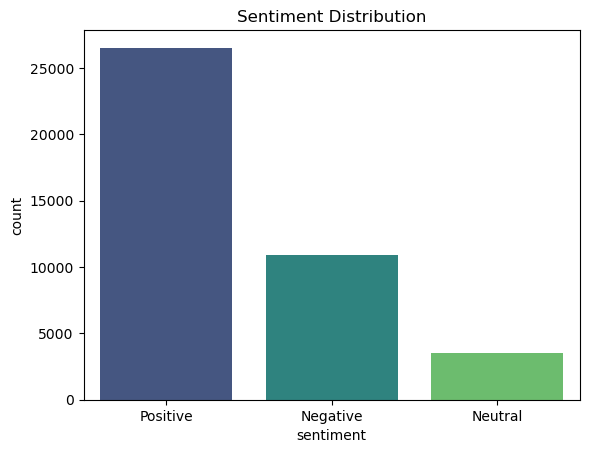

In [64]:
# Sentiment Counts
sentiment_counts = data['sentiment'].value_counts()
sns.countplot(data=data, x='sentiment', palette='viridis')
plt.title("Sentiment Distribution")
plt.show()


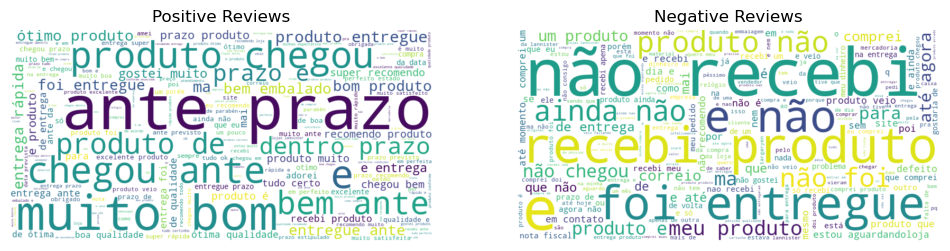

In [65]:
# Word Cloud for Positive and Negative Reviews
positive_text = ' '.join(data[data['sentiment'] == 'Positive']['cleaned_review'])
negative_text = ' '.join(data[data['sentiment'] == 'Negative']['cleaned_review'])

positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.title("Positive Reviews")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.title("Negative Reviews")
plt.axis('off')
plt.show()


In [66]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = tfidf.fit_transform(data['cleaned_review']).toarray()
y = data['sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0})

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [67]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82      2151
           1       0.38      0.07      0.12       730
           2       0.89      0.94      0.92      5315

    accuracy                           0.85      8196
   macro avg       0.68      0.63      0.62      8196
weighted avg       0.81      0.85      0.82      8196



In [68]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.73      0.91      0.81      2151
           1       0.35      0.08      0.13       730
           2       0.91      0.92      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.66      0.63      0.62      8196
weighted avg       0.81      0.84      0.82      8196



In [69]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.73      0.87      0.80      2151
           1       0.30      0.02      0.04       730
           2       0.89      0.93      0.91      5315

    accuracy                           0.84      8196
   macro avg       0.64      0.61      0.58      8196
weighted avg       0.79      0.84      0.80      8196



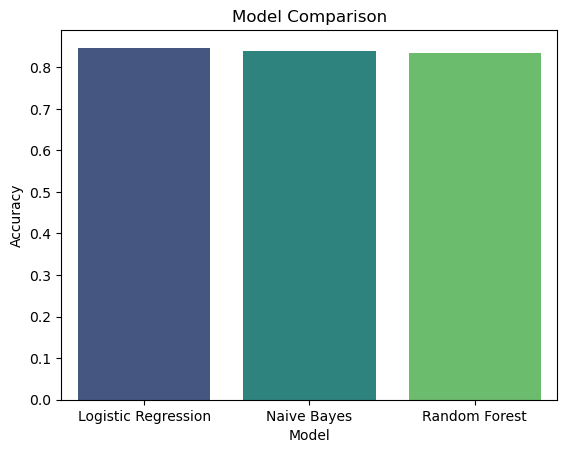

In [70]:
# Combine results into a DataFrame for comparison
models = ['Logistic Regression', 'Naive Bayes', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_rf),
]

results = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
sns.barplot(data=results, x='Model', y='Accuracy', palette='viridis')
plt.title("Model Comparison")
plt.show()


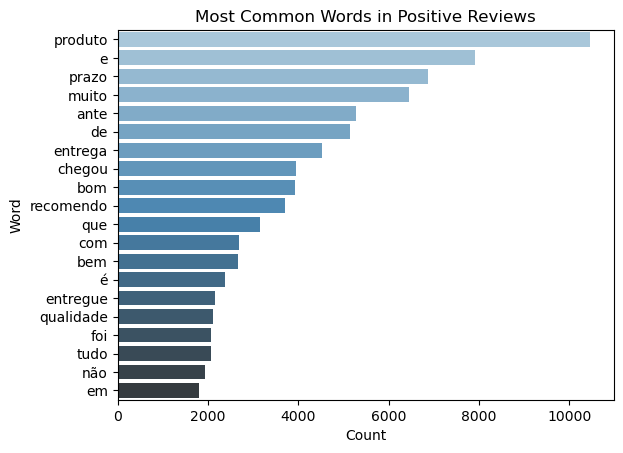

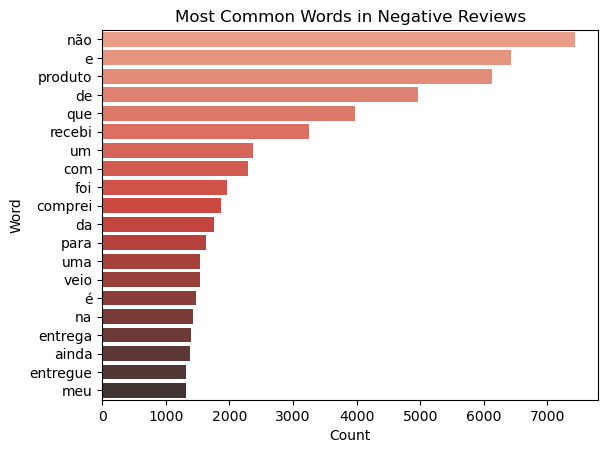

In [71]:
positive_words = Counter(" ".join(data[data['sentiment'] == 'Positive']['cleaned_review']).split()).most_common(20)
negative_words = Counter(" ".join(data[data['sentiment'] == 'Negative']['cleaned_review']).split()).most_common(20)

positive_df = pd.DataFrame(positive_words, columns=['Word', 'Count'])
negative_df = pd.DataFrame(negative_words, columns=['Word', 'Count'])

sns.barplot(data=positive_df, x='Count', y='Word', palette='Blues_d')
plt.title("Most Common Words in Positive Reviews")
plt.show()

sns.barplot(data=negative_df, x='Count', y='Word', palette='Reds_d')
plt.title("Most Common Words in Negative Reviews")
plt.show()


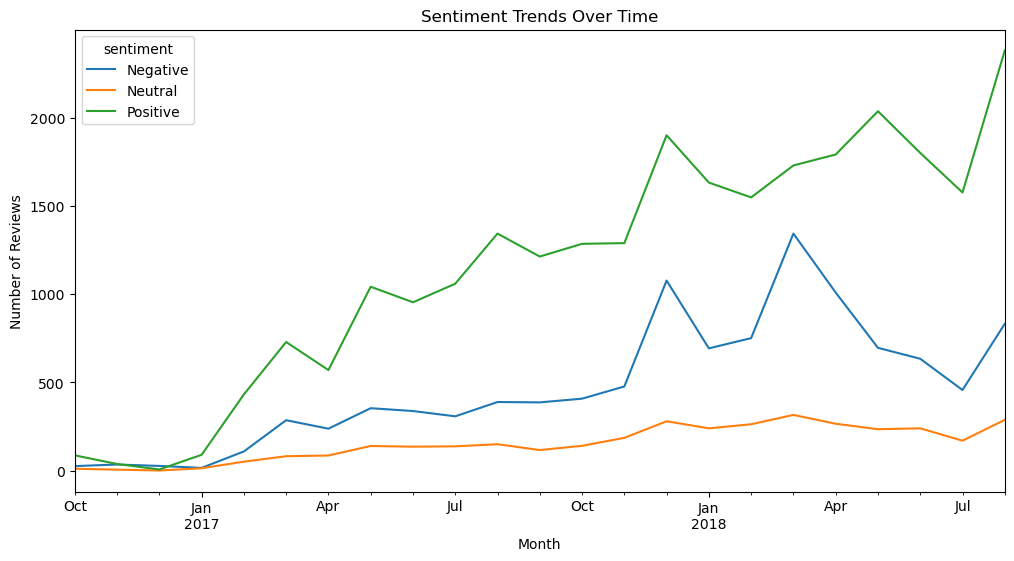

In [72]:
data['review_date'] = pd.to_datetime(data['review_creation_date'])
sentiment_trend = data.groupby([data['review_date'].dt.to_period('M'), 'sentiment']).size().unstack()

sentiment_trend.plot(kind='line', figsize=(12, 6))
plt.title("Sentiment Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()